In [27]:
# 深度可分离卷积

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.6.4
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.6.4
keras.api._v2.keras 2.6.0


In [29]:
!nvidia-smi

Tue Jul 26 10:19:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |  15977MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                             padding='same', activation='selu',
                             input_shape=(28, 28, 1)))
# param 3*3*32+32=320
# Output Shape(None, 28, 28, 32)
model.add(keras.layers.SeparableConv2D(filters=32, kernel_size=3,
                                       padding='same', activation='selu'))
# N_depthwise: 32*3*3=288       上一层通道数*kernel_size
# N_pointwise: 1*1*32*32=1024   1*1*上一层通道数*本层通道数
# param: N_depthwise+N_pointwise+bias=288+1024+32=1344
# Output Shape(None, 28, 28, 32)
model.add(keras.layers.MaxPool2D(pool_size=2))
# (size-pool_size)//stride=(28-2)//2+1=14
model.add(keras.layers.SeparableConv2D(filters=64, kernel_size=3,
                                       padding='same', activation='selu'))
# N_depthwise: 32*3*3=288       上一层通道数*kernel_size
# N_pointwise: 1*1*32*64=2048   1*1*上一层通道数*本层通道数
# param: N_depthwise+N_pointwise+bias=288+2048+64=2400
# Output Shape(None, 14, 14, 64)
model.add(keras.layers.SeparableConv2D(filters=64, kernel_size=3,
                                       padding='same', activation='selu'))
# N_depthwise: 64*3*3=576
# N_pointwise: 1*1*64*64=4096   1*1*上一层通道数*本层通道数
# param: N_depthwise+N_pointwise+bias=576+4096+64=4376
# Output Shape(None, 14, 14, 64)
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.SeparableConv2D(filters=128, kernel_size=3,
                                       padding='same', activation='selu'))
model.add(keras.layers.SeparableConv2D(filters=128, kernel_size=3,
                                       padding='same', activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
# Output Shape(None, 3, 3, 128)
model.add(keras.layers.Flatten())
# Output Shape(None, 3*3*128=1152)
model.add(keras.layers.Dense(128, activation='selu'))
# paras: 1152*128+128=147584
model.add(keras.layers.Dense(10, activation="softmax"))
# paras: 128*10+10=1290
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [33]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 28, 28, 32)        1344      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
separable_conv2d_6 (Separabl (None, 14, 14, 64)        2400      
_________________________________________________________________
separable_conv2d_7 (Separabl (None, 14, 14, 64)        4736      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
separable_conv2d_8 (Separabl (None, 7, 7, 128)        

In [34]:
print(model.variables)

[<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[-1.02506027e-01, -1.90363526e-02,  1.55430734e-02,
           1.04613453e-01,  1.11905590e-01,  4.87576574e-02,
          -1.37406230e-01, -3.15943211e-02,  1.23917162e-02,
           4.27455306e-02, -3.98144424e-02, -1.42004713e-01,
           1.18720725e-01,  1.27941594e-01, -3.46963033e-02,
          -3.55776101e-02, -7.21368343e-02,  4.20836359e-02,
           1.19282976e-01,  1.37940481e-01, -6.51192665e-03,
          -1.25457004e-01, -1.28564239e-02,  1.00035205e-01,
           6.51348978e-02, -1.28769130e-01, -5.64147979e-02,
           7.99693167e-02,  5.51512837e-02,  4.44879830e-02,
           3.61429900e-02, -6.02050647e-02]],

        [[-2.97195688e-02,  7.95862228e-02, -1.40676126e-01,
           1.00002706e-01,  1.10692963e-01, -7.51928613e-02,
          -1.29584491e-01,  1.18346259e-01,  1.34016708e-01,
           6.70215786e-02,  1.12734422e-01,  1.00126699e-01,
           4.06334996e-

In [35]:
print(model.layers)
logdir = './separable-cnn-selu-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks=callbacks)

[<keras.layers.convolutional.Conv2D object at 0x7f850c076610>, <keras.layers.convolutional.SeparableConv2D object at 0x7f850c076a10>, <keras.layers.pooling.MaxPooling2D object at 0x7f850c51e6d0>, <keras.layers.convolutional.SeparableConv2D object at 0x7f850c096f50>, <keras.layers.convolutional.SeparableConv2D object at 0x7f850c0a3750>, <keras.layers.pooling.MaxPooling2D object at 0x7f850c05d150>, <keras.layers.convolutional.SeparableConv2D object at 0x7f850c630210>, <keras.layers.convolutional.SeparableConv2D object at 0x7f850c0e4ad0>, <keras.layers.pooling.MaxPooling2D object at 0x7f850c0723d0>, <keras.layers.core.Flatten object at 0x7f850bebc210>, <keras.layers.core.Dense object at 0x7f850c0e4110>, <keras.layers.core.Dense object at 0x7f850c06e3d0>]


2022-07-26 10:19:48.207584: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-26 10:19:48.207629: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-07-26 10:19:48.381241: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-26 10:19:48.381439: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/100
   2/1719 [..............................] - ETA: 4:31 - loss: 2.3022 - accuracy: 0.0938 

2022-07-26 10:19:49.215000: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-26 10:19:49.215043: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-07-26 10:19:49.385896: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-26 10:19:49.386425: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


  40/1719 [..............................] - ETA: 21s - loss: 2.3039 - accuracy: 0.1063

2022-07-26 10:19:49.512739: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 205 callback api events and 202 activity events. 
2022-07-26 10:19:49.519432: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-26 10:19:49.525580: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./separable-cnn-selu-callbacks/train/plugins/profile/2022_07_26_10_19_49

2022-07-26 10:19:49.530806: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./separable-cnn-selu-callbacks/train/plugins/profile/2022_07_26_10_19_49/564be1680a9c.trace.json.gz
2022-07-26 10:19:49.539846: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./separable-cnn-selu-callbacks/train/plugins/profile/2022_07_26_10_19_49

2022-07-26 10:19:49.541731: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_pro

1719/1719 [==============================] - 9s 5ms/step - loss: 2.3029 - accuracy: 0.1020 - val_loss: 2.3027 - val_accuracy: 0.1392
Epoch 2/100
1719/1719 [==============================] - 8s 4ms/step - loss: 2.2251 - accuracy: 0.1791 - val_loss: 1.1764 - val_accuracy: 0.5908
Epoch 3/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.8719 - accuracy: 0.6735 - val_loss: 0.7496 - val_accuracy: 0.7102
Epoch 4/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7114 - accuracy: 0.7319 - val_loss: 0.7535 - val_accuracy: 0.7116
Epoch 5/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6229 - accuracy: 0.7661 - val_loss: 0.5583 - val_accuracy: 0.7952
Epoch 6/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5421 - accuracy: 0.7951 - val_loss: 0.4973 - val_accuracy: 0.8112
Epoch 7/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4862 - accuracy: 0.8188 - val_loss: 0.4490 - val_accuracy: 0.83

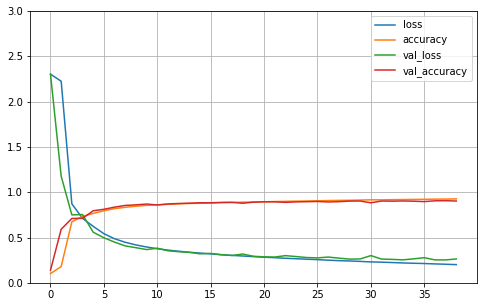

In [36]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 3)
    plt.show()


plot_learning_curves(history)

In [37]:
print(model.evaluate(x_test_scaled, y_test, verbose=0))


[0.284401535987854, 0.8985999822616577]
